# Análise de Ausências Empregados

## Objetivo

Calcular para cada mês do intervalo informado, quantos dias cada empregado esteve ausente e qual a representatividade destas ausências em absenteismo 
(soma_ausencias / dias_uteis)

## Dados

Os dados foram capturados do por IA, anotando cada dia ausente para cada empregado da unidade. Foram consideradas ausencias as Licencias Medicas

## Entregas

- Absenteismo Geral
- Absenteismo por Fucionario
- Absenteismo por Mês
- Absenteismo por Dias da semana
- Absenteismo por Missão

## Obs: 
Essa demanda foi feita no meu estágio na Caixa Economica Federal, não posso usar os dados reais para essa demanda, sendo assim, pedi para IA criar uma base de dados semlhantes

## Importando Biblioteca ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import matplotlib.patheffects as pe

from datetime import date, timedelta
from pandas.tseries.offsets import CustomBusinessDay
from matplotlib.ticker import FuncFormatter

## Dados

Nesta etapa, mostra como importei os dados e tratei

### Carregando os tabela

In [2]:
df = pd.read_csv('dataset/BASE_DEPARTAMENTOS_MAIS_AUSENCIAS.csv', sep = ';', encoding="cp1252")

### Vizualizando a tabela

In [3]:
df.head()

,NOMES,DATAS,MISSAO
0,ANA GOMES PINTO DOS SANTOS,NaN,Facilities
1,ANA LIMA DANTAS DE VIEIRA,28/10/2025,Planejamento e EstratÃ©gia
2,ANA LIMA DANTAS DE VIEIRA,18/12/2025,Planejamento e EstratÃ©gia
3,ANA RIBEIRO PINTO DE RIBEIRO,NaN,Controladoria
4,ANA TEIXEIRA PINTO DE FERREIRA,NaN,Atendimento ao Cliente


### Verificando o tipo do dados e sua quantidade de linhas, se há nullos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOMES   237 non-null    object
 1   DATAS   138 non-null    object
 2   MISSAO  237 non-null    object
dtypes: object(3)
memory usage: 5.7+ KB


### Arrumando o tipo de data e também adicionando uma coluna com os dias da semana

In [5]:
# transformando a coluna em tipo data / transformando em null os dados vazios

df_data_corrigido = df.copy()

df_data_corrigido['DATAS'] = df_data_corrigido['DATAS'].astype('string').str.strip().replace('', pd.NA)

# transformando em tipo data
df_data_corrigido.loc[:,'DATAS'] = pd.to_datetime(df_data_corrigido.loc[:,'DATAS'], dayfirst = True, errors = 'coerce')

# removendo as horas da variável
df_data_corrigido.loc[:,'DATAS'] = df_data_corrigido.loc[:,'DATAS'].dt.date

df_add_dias = df_data_corrigido.copy()

# acrescentando dias da semana atraves das datas
mapa_pt = {
    "Monday": "Segunda-feira",
    "Tuesday": "Terça-feira",
    "Wednesday": "Quarta-feira",
    "Thursday": "Quinta-feira",
    "Friday": "Sexta-feira",
    "Saturday": "Sábado",
    "Sunday": "Domingo",
}
df_add_dias["DIA_SEMANA"] = df_add_dias["DATAS"].dt.day_name().map(mapa_pt)

df_add_dias = df_data_corrigido.copy()

# acrescentando dias da semana atraves das datas
mapa_pt = {
    "Monday": "Segunda-feira",
    "Tuesday": "Terça-feira",
    "Wednesday": "Quarta-feira",
    "Thursday": "Quinta-feira",
    "Friday": "Sexta-feira",
    "Saturday": "Sábado",
    "Sunday": "Domingo",
}
df_add_dias["DIA_SEMANA"] = df_add_dias["DATAS"].dt.day_name().map(mapa_pt)

df_add_dias.head()

,NOMES,DATAS,MISSAO,DIA_SEMANA
0,ANA GOMES PINTO DOS SANTOS,NaT,Facilities,NaN
1,ANA LIMA DANTAS DE VIEIRA,2025-10-28,Planejamento e EstratÃ©gia,Terça-feira
2,ANA LIMA DANTAS DE VIEIRA,2025-12-18,Planejamento e EstratÃ©gia,Quinta-feira
3,ANA RIBEIRO PINTO DE RIBEIRO,NaT,Controladoria,NaN
4,ANA TEIXEIRA PINTO DE FERREIRA,NaT,Atendimento ao Cliente,NaN


## Padrões

Nesse topico algumas variaveis foram definidas para como periodo de 01 de Agosto de 2025 a dia 30 de janeiro de 2026 (apliquei uma função que contava somente os dias uteis desse periodo, que são 128 dias ) e a quantidade de Fucionários, que são 141 fucionarios

### Parâmetros do período (automático)

O que faz: define inicio_dt e fim_dt automaticamente a partir da menor e maior data da sua coluna DATAS.
Por que: evita hardcode e garante que o resto do pipeline sempre use o período correto.

In [6]:
# Garante tipo datetime (dd/mm/aaaa)
df_add_dias["DATAS"] = pd.to_datetime(df_add_dias["DATAS"], dayfirst=True, errors="coerce")
if df_add_dias["DATAS"].isna().all():
    raise ValueError("Nenhuma data válida encontrada em df_add_dias['DATAS'].")

acolchoar_dias = 0  # ajuste se quiser expandir o intervalo (ex.: 3 dias a mais nas pontas)
inicio_dt = df_add_dias["DATAS"].min().normalize() - pd.Timedelta(days=acolchoar_dias)
fim_dt    = df_add_dias["DATAS"].max().normalize() + pd.Timedelta(days=acolchoar_dias)

print("Período:", inicio_dt.date(), "→", fim_dt.date())

Período: 2025-08-01 → 2026-01-30


### Datas móveis (Páscoa, Carnaval etc.)
O que faz: Implementa funções para calcular feriados móveis (Páscoa, Paixão, Corpus Christi, Carnaval).
Por que: Esses feriados mudam todo ano e são necessários para um calendário correto.

In [7]:
# datas móveis

def easter_date(y: int) -> date:
    """Páscoa (algoritmo Meeus/Jones/Butcher)"""
    a = y % 19
    b = y // 100
    c = y % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19*a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2*e + 2*i - h - k) % 7
    m = (a + 11*h + 22*l) // 451
    month = (h + l - 7*m + 114) // 31
    day   = ((h + l - 7*m + 114) % 31) + 1
    return date(y, month, day)

def carnaval_dates(y: int):
    """Carnaval (segunda e terça) e Cinzas (quarta até 14h)"""
    pascoa = easter_date(y)
    return (
        pascoa - timedelta(days=48),  # segunda
        pascoa - timedelta(days=47),  # terça
        pascoa - timedelta(days=46),  # cinzas
    )

def paixao_de_cristo(y: int):
    return easter_date(y) - timedelta(days=2)  # sexta-feira santa

def corpus_christi(y: int):
    return easter_date(y) + timedelta(days=60)

### Feriados nacionais + locais (DF) por ano

O que faz: monta a tabela de feriados (fixos + móveis) e pontos facultativos (separados).
Por que: você pode escolher incluir/ excluir pontos facultativos do cálculo.

In [8]:
# feriados por ano (Nacionais + DF)
def feriados_br_df(ano: int, incluir_pontos_facultativos: bool = False):
    # Feriados nacionais fixos
    feriados = {
        date(ano, 1,  1): "Confraternização Universal (Nacional)",
        date(ano, 4, 21): "Tiradentes (Nacional) + Aniversário de Brasília (DF)",
        date(ano, 5,  1): "Dia do Trabalho (Nacional)",
        date(ano, 9,  7): "Independência do Brasil (Nacional)",
        date(ano,10, 12): "Nossa Senhora Aparecida (Nacional)",
        date(ano,11,  2): "Finados (Nacional)",
        date(ano,11, 15): "Proclamação da República (Nacional)",
        date(ano,11, 20): "Dia da Consciência Negra (Nacional)",
        date(ano,12, 25): "Natal (Nacional)",
    }
    # móveis (nacionais)
    feriados[paixao_de_cristo(ano)] = "Paixão de Cristo / Sexta-feira Santa (Nacional)"
    # Locais (DF)
    feriados[date(ano,11,30)] = "Dia do Evangélico (DF - Lei nº 963/1995)"
    feriados[corpus_christi(ano)] = "Corpus Christi (DF - feriado/ponto local)"

    # pontos facultativos (separados)
    pontos = {}
    seg, ter, qua = carnaval_dates(ano)
    pontos[seg] = "Carnaval (ponto facultativo)"
    pontos[ter] = "Carnaval (ponto facultativo)"
    pontos[qua] = "Quarta-feira de Cinzas até 14h (ponto facultativo)"
    pontos[date(ano,12,24)] = "Véspera de Natal (ponto facultativo após 14h)"
    pontos[date(ano,12,31)] = "Véspera de Ano-Novo (ponto facultativo após 14h)"

    if incluir_pontos_facultativos:
        feriados = {**feriados, **pontos}

    return feriados, pontos

### Feriados do intervalo (todos os anos) e DataFrame final

O que faz: gera a lista completa de feriados (e pontos) para todos os anos entre inicio_dt e fim_dt, e prepara o feriados_df.
Por que: evita limitar a um ano; funciona para períodos cruzando anos.

In [9]:
# feriados do intervalo
anos = range(inicio_dt.year, fim_dt.year + 1)
feriados_dict = {}
pontos_dict   = {}

for ano in anos:
    f, p = feriados_br_df(ano, incluir_pontos_facultativos=False)
    feriados_dict.update(f)
    pontos_dict.update(p)

feriados_df = (
    pd.DataFrame(
        [{"DATA": pd.to_datetime(d), "NOME": n, "TIPO": "FERIADO"} for d, n in feriados_dict.items()]
        +
        [{"DATA": pd.to_datetime(d), "NOME": n, "TIPO": "PONTO FACULTATIVO"} for d, n in pontos_dict.items()]
    )
    .sort_values("DATA")
    .reset_index(drop=True)
)

# se quiser considerar pontos facultativos como feriado nos cálculos, mude para .isin(["FERIADO","PONTO FACULTATIVO"])
feriados_idx = pd.DatetimeIndex(
    feriados_df.loc[feriados_df["TIPO"] == "FERIADO", "DATA"].dt.normalize().unique()
)

# feriados dentro do período
feriados_periodo = feriados_df[(feriados_df["DATA"] >= inicio_dt) & (feriados_df["DATA"] <= fim_dt)].copy()

### Marcação de feriados no seu DataFrame

O que faz: filtra o seu DF para o período e marca colunas indicando se cada data é feriado e o nome do feriado.
Por que: útil para flag de ausência em feriado, validações e auditorias.

In [10]:
# marcação de feriados no seu DataFrame
df_periodo = df_add_dias[(df_add_dias["DATAS"] >= inicio_dt) & (df_add_dias["DATAS"] <= fim_dt)].copy()
df_periodo["_DATA"] = df_periodo["DATAS"].dt.normalize()

# conjuntos normalizados
feriados_datas = set(feriados_df.loc[feriados_df["TIPO"] == "FERIADO", "DATA"].dt.normalize())
pontos_datas   = set(feriados_df.loc[feriados_df["TIPO"] == "PONTO FACULTATIVO", "DATA"].dt.normalize())

# mapas
mapa_nome_feriado = {pd.to_datetime(d).normalize(): n for d, n in feriados_dict.items()}
mapa_nome_ponto   = {pd.to_datetime(d).normalize(): n for d, n in pontos_dict.items()}

# flags e nomes
df_periodo["E_FERIADO"]    = df_periodo["_DATA"].isin(feriados_datas)
df_periodo["NOME_FERIADO"] = df_periodo["_DATA"].map(mapa_nome_feriado)

df_periodo["E_PONTO_FACULTATIVO"]    = df_periodo["_DATA"].isin(pontos_datas)
df_periodo["NOME_PONTO_FACULTATIVO"] = df_periodo["_DATA"].map(mapa_nome_ponto)

df_periodo.drop(columns=["_DATA"], inplace=True)

df_periodo.head()

,NOMES,DATAS,MISSAO,DIA_SEMANA,E_FERIADO,NOME_FERIADO,E_PONTO_FACULTATIVO,NOME_PONTO_FACULTATIVO
1,ANA LIMA DANTAS DE VIEIRA,2025-10-28,Planejamento e EstratÃ©gia,Terça-feira,False,NaN,False,NaN
2,ANA LIMA DANTAS DE VIEIRA,2025-12-18,Planejamento e EstratÃ©gia,Quinta-feira,False,NaN,False,NaN
7,BRUNO NOGUEIRA MARTINS DE SOUZA,2025-10-23,Compras e Suprimentos,Quinta-feira,False,NaN,False,NaN
8,BRUNO NOGUEIRA MARTINS DE SOUZA,2025-11-20,Compras e Suprimentos,Quinta-feira,True,Dia da Consciência Negra (Nacional),False,NaN
9,BRUNO SANTOS BARBOSA DE RODRIGUES,2025-09-19,Engenharia de Dados,Sexta-feira,False,NaN,False,NaN


### Dias úteis do período (com e sem feriado)

O que faz: calcula total de dias úteis do período, e remove feriados.
Por que: esses números entram nos denominadores de várias métricas (se você desejar).

In [11]:
# dias úteis do período
from pandas.tseries.offsets import CustomBusinessDay

# dias úteis padrão (segunda a sexta)
dias_uteis = pd.bdate_range(start=inicio_dt, end=fim_dt)

# excluir somente feriados:
feriados_para_excluir = pd.to_datetime(sorted(list(feriados_datas)))

dias_sem_feriado = dias_uteis.difference(pd.DatetimeIndex(feriados_para_excluir))
dias_previstos = len(dias_sem_feriado)

print("Dias úteis (seg-sex):", len(dias_uteis))
print("Dias úteis sem feriados:", dias_previstos)

Dias úteis (seg-sex): 131
Dias úteis sem feriados: 128


### Diagnóstico

In [12]:
total_funcionarios = df_add_dias['NOMES'].nunique()

print("Total de funcionários:", total_funcionarios)
print("Período:", inicio_dt.date(), "a", fim_dt.date())

print("\nFeriados no período:")
print(
    feriados_periodo[feriados_periodo["TIPO"] == "FERIADO"][["DATA","NOME"]]
    .to_string(index=False)
)

feriados_uteis = pd.DatetimeIndex(sorted(feriados_datas)).intersection(pd.bdate_range(inicio_dt, fim_dt))
print("\nFeriados que caem em dias úteis no período:")
for d in feriados_uteis:
    print(d.date(), "-", mapa_nome_feriado.get(pd.to_datetime(d).normalize()))

Total de funcionários: 141
Período: 2025-08-01 a 2026-01-30

Feriados no período:
      DATA                                     NOME
2025-09-07       Independência do Brasil (Nacional)
2025-10-12       Nossa Senhora Aparecida (Nacional)
2025-11-02                       Finados (Nacional)
2025-11-15      Proclamação da República (Nacional)
2025-11-20      Dia da Consciência Negra (Nacional)
2025-11-30 Dia do Evangélico (DF - Lei nº 963/1995)
2025-12-25                         Natal (Nacional)
2026-01-01    Confraternização Universal (Nacional)

Feriados que caem em dias úteis no período:
2025-11-20 - Dia da Consciência Negra (Nacional)
2025-12-25 - Natal (Nacional)
2026-01-01 - Confraternização Universal (Nacional)


## Absenteismo Geral

Nesta etapa, analisamos o absenteismo geral e também por fucionario

### Calculando os dias ausentes por fucionario (dias distintos)

In [13]:
# importando dados do df original
df_dados_geral = df_add_dias.copy()

In [14]:
# Quantos dias ausentes por funcionario (dias distintos)
dias_ausentes_por_pessoa = df_periodo.groupby("NOMES")["DATAS"].nunique()

### Calculando o absenteismo por Fucionario

Calculo = dias_ausentes_por_fucionario/dias_previstos

In [15]:
# resultado final do Absenteismo dos fucionarios
resultado_dados_geral = dias_ausentes_por_pessoa.to_frame(name="DIAS_AUSENTES")
resultado_dados_geral["DIAS_PREVISTOS"] = dias_previstos

resultado_dados_geral['ABSENTEISMO_%'] = (
    (resultado_dados_geral['DIAS_AUSENTES'] / resultado_dados_geral['DIAS_PREVISTOS']) * 100
).round(2)

# ordenar do maior para o menor
resultado_dados_geral = resultado_dados_geral.sort_values("ABSENTEISMO_%", ascending=False)

### Calculando o Absenteismo Geral
Calculo = dias_ausentes_por_fucionario/dias_previstos * Quantidade_de_fucionario

In [16]:
# total previsto de "dias-pessoa" = 71 pessoas * dias úteis do período
denominador_geral = total_funcionarios * dias_previstos

# total de dias ausentes (somando todo mundo que apareceu no df_periodo)
total_dias_ausentes = dias_ausentes_por_pessoa.sum()

# indice geral (%)
absenteismo_geral = (
    round((total_dias_ausentes / denominador_geral) * 100, 2)
    if denominador_geral > 0
    else np.nan
)

# qtd de funcionarios com registro no período
funcionarios_com_registro_no_periodo = df_periodo["NOMES"].nunique()
total_dias_ausentes

138

### Calculo Mediana e Media do absenteismo por fucionario

In [17]:
# media do absenteísmo (%)
media_absenteismo = resultado_dados_geral["ABSENTEISMO_%"].mean()

# mediana do absenteísmo (%)
mediana_absenteismo = resultado_dados_geral["ABSENTEISMO_%"].median()

### Resumo das Medidas

In [41]:
# vizualisação dos resultados
display(resultado_dados_geral)

print(f"Dias previstos no período (por funcionário): {dias_previstos}")
print(f"Funcionários com registro no período: {funcionarios_com_registro_no_periodo}")
print(f"Total de funcionários considerados: {total_funcionarios}")
print(f"Absenteísmo geral (todos os fucionarios) (%): {absenteismo_geral}")

,DIAS_AUSENTES,DIAS_PREVISTOS,ABSENTEISMO_%
NOMES,,,
WAGNER SOUZA SANTANA DA COSTA,5,128,3.91
VICTOR DANTAS ALVES DE MOURA,5,128,3.91
JULIA AMARAL ROCHA DE RODRIGUES,5,128,3.91
DANIEL VIEIRA ALMEIDA DE SANTANA,5,128,3.91
FERNANDA BRAGA DANTAS DE ARAUJO,5,128,3.91
RAFAELLA GOMES SANTANA DO CARMO,5,128,3.91
ELISA MORAES LOPES DE ROCHA,5,128,3.91
ENZO VIEIRA BEZERRA DE RIBEIRO,5,128,3.91
THIAGO DIAS MORAES DE VIEIRA,4,128,3.12


Dias previstos no período (por funcionário): 128
Funcionários com registro no período: 42
Total de funcionários considerados: 141
Absenteísmo geral (todos os fucionarios) (%): 0.76


## Absenteismo por Mes

Nesta etapa, organizamos os dados montando uma tabela que traz para cada empregado a quantidade de ausencias efetivas em um determinado mês, o absenteismo do mes, e dias uteis de cada mes

### Definido o Perido mensal (Dias Uteis em Cada Mes)

In [19]:
considerar_ponto_facultativo_como_feriado = False

if considerar_ponto_facultativo_como_feriado:
    feriados_idx = pd.DatetimeIndex(
        feriados_df.loc[feriados_df["TIPO"].isin(["FERIADO","PONTO FACULTATIVO"]), "DATA"]
        .dt.normalize()
        .unique()
    )
else:
    feriados_idx = pd.DatetimeIndex(
        feriados_df.loc[feriados_df["TIPO"]=="FERIADO", "DATA"]
        .dt.normalize()
        .unique()
    )

dias_previstos_por_mes = (
    pd.DataFrame({"DATA": dias_sem_feriado})
      .assign(
          MES=lambda x: x["DATA"].dt.to_period("M"),
          MES_LABEL=lambda x: x["DATA"].dt.strftime("%b/%Y").str.capitalize()
      )
      .groupby(["MES","MES_LABEL"], as_index=False)
      .size()
      .rename(columns={"size":"DIAS_PREVISTOS"})
)

### Criando uma Tabela Para Dias Ausentes por Funcionario e por Mes

In [20]:
df_periodo = df_add_dias[(df_add_dias["DATAS"]>=inicio_dt) & (df_add_dias["DATAS"]<=fim_dt)].copy()
df_periodo["MES"] = df_periodo["DATAS"].dt.to_period("M")
df_periodo["MES_LABEL"] = df_periodo["DATAS"].dt.strftime("%b/%Y").str.capitalize()

ausencias_mensais = (
    df_periodo.groupby(["NOMES","MES","MES_LABEL"])
              .size()
              .reset_index(name="DIAS_AUSENTES")
)

### Criando a Tabela Lista de Fucionario

In [21]:
lista_funcionarios = (
    df_add_dias["NOMES"].dropna().astype(str).unique().tolist()
)
meses_periodo = dias_previstos_por_mes["MES"].unique().tolist()

### Juntando as Tabelas Criandas Anteriomente

Nesta etapa, organizamos os dados montando uma tabela que traz para cada empregado a quantidade de ausencias efetivas em um determinado mês. Se o funcionário não faltou no mes, uma entrada na tabela será registrada com o valor zero.

In [22]:
grade = pd.MultiIndex.from_product(
    [lista_funcionarios, meses_periodo],
    names=["NOMES","MES"]
).to_frame(index=False)

### Calcula o Absenteismo em Cada Mes (Geral Por Mes)

calculo = dias de ausencia / perido * numeros de fucionario

In [23]:
tabela_mensal = (
    grade
    # junta ausências
    .merge(ausencias_mensais[["NOMES","MES","DIAS_AUSENTES"]],
           on=["NOMES","MES"], how="left")
    # junta dias previstos
    .merge(dias_previstos_por_mes[["MES","MES_LABEL","DIAS_PREVISTOS"]],
           on="MES", how="left")
)

tabela_mensal["DIAS_AUSENTES"] = pd.to_numeric(tabela_mensal["DIAS_AUSENTES"], errors="coerce").fillna(0).astype(int)

tabela_mensal["ABSENTEISMO_MES_%"] = np.where(
    tabela_mensal["DIAS_PREVISTOS"].fillna(0) > 0,
    (tabela_mensal["DIAS_AUSENTES"] / tabela_mensal["DIAS_PREVISTOS"]) * 100,
    np.nan
).round(2)

tabela_mensal = tabela_mensal.sort_values(["NOMES","MES"]).reset_index(drop=True)

### Preparando os Dados Para Realiza o Calculo absenteismo do Mes Geral

In [24]:
tmp = tabela_mensal.copy()
tmp.loc[:, "DIAS_AUSENTES"] = pd.to_numeric(tmp.loc[:, "DIAS_AUSENTES"], errors="coerce").fillna(0)

dpm = dias_previstos_por_mes.copy()

# se a coluna existir e não for PeriodDtype, converte para PeriodIndex mensal
if "MES" in dpm.columns and not isinstance(dpm["MES"].dtype, pd.PeriodDtype):
    dpm.loc[:, "MES"] = pd.PeriodIndex(dpm.loc[:, "MES"], freq="M")

### Base: dias úteis do mês (uma linha por mês)

In [25]:
# dias úteis do mês (uma linha por mês)
dias_uteis_mes = (
    dpm.loc[:, ["MES", "MES_LABEL", "DIAS_PREVISTOS"]]
       .rename(columns={"DIAS_PREVISTOS": "DIAS_UTEIS_MES"})
       .drop_duplicates(subset=["MES"])
)

### Headcount do mês (qtde de colaboradores com qualquer registro no mês)

In [26]:
# headcount do mês (empregados com qualquer registro no mês)
headcount_mes = (
    tmp.groupby(["MES", "MES_LABEL"], as_index=False)["NOMES"]
       .nunique()
       .rename(columns={"NOMES": "HEADCOUNT_MES"})
)

### Ausências totais do mês

In [27]:
# ausências totais do mês
ausencias_totais_mes = (
    tmp.groupby(["MES", "MES_LABEL"], as_index=False)["DIAS_AUSENTES"]
       .sum()
       .rename(columns={"DIAS_AUSENTES": "DIAS_AUSENTES_TOTAL"})
)

### Junção das bases e normalização de tipos

In [28]:
resumo_geral_mensal = (
    dias_uteis_mes
      .merge(headcount_mes, on=["MES", "MES_LABEL"], how="left")
      .merge(ausencias_totais_mes, on=["MES", "MES_LABEL"], how="left")
)

resumo_geral_mensal["HEADCOUNT_MES"]      = pd.to_numeric(resumo_geral_mensal["HEADCOUNT_MES"], errors="coerce").fillna(0).astype(int)
resumo_geral_mensal["DIAS_UTEIS_MES"]     = pd.to_numeric(resumo_geral_mensal["DIAS_UTEIS_MES"], errors="coerce").astype(float)
resumo_geral_mensal["DIAS_AUSENTES_TOTAL"]= pd.to_numeric(resumo_geral_mensal["DIAS_AUSENTES_TOTAL"], errors="coerce").fillna(0).astype(float)



### Calculo = Ausencias / Presencias_mes

In [29]:
resumo_geral_mensal["PRESENCAS_TOTAIS"] = (
    resumo_geral_mensal["DIAS_UTEIS_MES"] * resumo_geral_mensal["HEADCOUNT_MES"]
).astype(float)

resumo_geral_mensal["ABSENTEISMO_GERAL_%"] = np.where(
    resumo_geral_mensal["PRESENCAS_TOTAIS"] > 0,
    (resumo_geral_mensal["DIAS_AUSENTES_TOTAL"] / resumo_geral_mensal["PRESENCAS_TOTAIS"]) * 100.0,
    np.nan
)
resumo_geral_mensal["ABSENTEISMO_GERAL_%"] = (
    pd.to_numeric(resumo_geral_mensal["ABSENTEISMO_GERAL_%"], errors="coerce")
      .astype(float)
      .round(2)
)


### Agregação mensal geral

Objetivo: gerar o resumo geral por mês:

In [30]:
resumo_geral_mensal = (
    resumo_geral_mensal
      .sort_values("MES")
      .reset_index(drop=True)[
          ["MES","MES_LABEL","DIAS_UTEIS_MES","HEADCOUNT_MES","PRESENCAS_TOTAIS","DIAS_AUSENTES_TOTAL","ABSENTEISMO_GERAL_%"]
      ]
)


### Resultado Mes

In [31]:
pd.set_option('display.max_rows', None)

display(tabela_mensal)

display(resumo_geral_mensal)

,NOMES,MES,DIAS_AUSENTES,MES_LABEL,DIAS_PREVISTOS,ABSENTEISMO_MES_%
0,ANA GOMES PINTO DOS SANTOS,2025-08,0,Aug/2025,21,0.00
1,ANA GOMES PINTO DOS SANTOS,2025-09,0,Sep/2025,22,0.00
2,ANA GOMES PINTO DOS SANTOS,2025-10,0,Oct/2025,23,0.00
3,ANA GOMES PINTO DOS SANTOS,2025-11,0,Nov/2025,19,0.00
4,ANA GOMES PINTO DOS SANTOS,2025-12,0,Dec/2025,22,0.00
5,ANA GOMES PINTO DOS SANTOS,2026-01,0,Jan/2026,21,0.00
6,ANA LIMA DANTAS DE VIEIRA,2025-08,0,Aug/2025,21,0.00
7,ANA LIMA DANTAS DE VIEIRA,2025-09,0,Sep/2025,22,0.00
8,ANA LIMA DANTAS DE VIEIRA,2025-10,1,Oct/2025,23,4.35
9,ANA LIMA DANTAS DE VIEIRA,2025-11,0,Nov/2025,19,0.00


,MES,MES_LABEL,DIAS_UTEIS_MES,HEADCOUNT_MES,PRESENCAS_TOTAIS,DIAS_AUSENTES_TOTAL,ABSENTEISMO_GERAL_%
0,2025-08,Aug/2025,21.0,141,2961.0,23.0,0.78
1,2025-09,Sep/2025,22.0,141,3102.0,29.0,0.93
2,2025-10,Oct/2025,23.0,141,3243.0,22.0,0.68
3,2025-11,Nov/2025,19.0,141,2679.0,27.0,1.01
4,2025-12,Dec/2025,22.0,141,3102.0,16.0,0.52
5,2026-01,Jan/2026,21.0,141,2961.0,21.0,0.71


## Absenteismo por Semana

Nesta etapa, organizamos os dados montando uma tabela que traz a quantidade de dias uteis, e de ausencias e absenteismo medio

### Organizando a Ordem dos Dias da Semana

In [32]:
map_pt = {
    0: "Segunda-feira", 1: "Terça-feira", 2: "Quarta-feira",
    3: "Quinta-feira",  4: "Sexta-feira"
}
ordem_dias = ["Segunda-feira","Terça-feira","Quarta-feira","Quinta-feira","Sexta-feira"]

# cria DataFrame a partir do DatetimeIndex
periodo_dia_semana = pd.DataFrame({"DATA": pd.DatetimeIndex(dias_sem_feriado)})

# garante dtype datetime64[ns]
periodo_dia_semana["DATA"] = pd.to_datetime(periodo_dia_semana["DATA"], errors="coerce")

periodo_dia_semana["DIA_SEMANA"] = periodo_dia_semana["DATA"].dt.dayofweek.map(map_pt)

ocorrencias = (
    periodo_dia_semana["DIA_SEMANA"]
    .value_counts()
    .reindex(ordem_dias, fill_value=0)
)

# mapeia o dia da semana dos seus eventos com o MESMO dicionário
df_periodo["DATAS"] = pd.to_datetime(df_periodo["DATAS"], errors="coerce")
df_periodo["DIA_SEMANA"] = df_periodo["DATAS"].dt.dayofweek.map(map_pt)

aus_por_dia = (
    df_periodo.groupby("DIA_SEMANA").size()
    .reindex(ordem_dias, fill_value=0)
)

tabela_dia_semana = pd.DataFrame({
    "DIA_SEMANA": ordem_dias,
    "AUSENCIAS": aus_por_dia.values.astype(int),
    "DIAS_NO_PERIODO": ocorrencias.values.astype(int)
})

### Realizando o Calculo de Absenteismo

calculo = ausencias / presenças_empreegados_dias_semana

In [33]:
headcount_constante = total_funcionarios 

tabela_dia_semana["HEADCOUNT"] = headcount_constante
tabela_dia_semana["PRESENCAS"] = (
    tabela_dia_semana["DIAS_NO_PERIODO"] * tabela_dia_semana["HEADCOUNT"]
)

total_aus = tabela_dia_semana["AUSENCIAS"].sum()

tabela_dia_semana["%_DAS_AUSENCIAS"] = (
    tabela_dia_semana["AUSENCIAS"] / total_aus * 100
).round(2)

tabela_dia_semana["ABSENTEISMO_%"] = (
    tabela_dia_semana["AUSENCIAS"] / tabela_dia_semana["PRESENCAS"] * 100
).round(2)

tabela_dia_semana

,DIA_SEMANA,AUSENCIAS,DIAS_NO_PERIODO,HEADCOUNT,PRESENCAS,%_DAS_AUSENCIAS,ABSENTEISMO_%
0,Segunda-feira,23,26,141,3666,16.67,0.63
1,Terça-feira,20,26,141,3666,14.49,0.55
2,Quarta-feira,33,26,141,3666,23.91,0.90
3,Quinta-feira,30,23,141,3243,21.74,0.93
4,Sexta-feira,32,27,141,3807,23.19,0.84


## Absenteismo por Missão

Nesta etapa, organizamos os dados montando uma tabela que traz quantidade de fucionarios que teve ausencia por missão, dias ausentes de todos os funcionarios, os dias previstos de todos os funcionarios e o absenteismo medio de cada missão

### Criando uma Tabela de Fucionários por Missão

In [34]:
# quantos funcionários únicos existem em cada missão
func_por_missao = (
    df.groupby("MISSAO")["NOMES"]
    .nunique()
    .rename("EMPREGADOS")
    .reset_index()
)

### Tabela de Dias Ausentes por Missão

In [35]:
dias_ausentes_missao = (
    df_periodo.groupby("MISSAO")
    .size()
    .rename("AUSENCIAS")
    .reset_index()
)


### Realizando o Calculo de Absenteismo

Calculo = ausencias_por_missão / (periodos_por_missao * empregados_por_missão)

O resultado final tem a quantidade de fucionarios que teve ausencia por missão, dias ausentes de todos os funcionarios, os dias previstos de todos os funcionarios
e o absenteismo medio de cada missão

In [36]:
resultado_missao = (
    func_por_missao.merge(dias_ausentes_missao, on="MISSAO", how="left")
)

# missões sem ausências ficam como NaN, então vira 0
resultado_missao["AUSENCIAS"] = resultado_missao["AUSENCIAS"].fillna(0).astype(int)

# dias previstos por missão = funcionários da missão * dias úteis do período
resultado_missao["DIAS_PREVISTOS_POR_MISSAO"] = resultado_missao["EMPREGADOS"] * dias_previstos

# absenteísmo %
resultado_missao["ABSENTEISMO_%"] = (
    (resultado_missao["AUSENCIAS"] / resultado_missao["DIAS_PREVISTOS_POR_MISSAO"]) * 100
).round(2)

# ordenar do maior para o menor
resultado_missao = resultado_missao.sort_values("ABSENTEISMO_%", ascending=False)

resultado_missao


,MISSAO,EMPREGADOS,AUSENCIAS,DIAS_PREVISTOS_POR_MISSAO,ABSENTEISMO_%
6,Contabilidade,5,12,640,1.88
15,OperaÃ§Ãµes,4,9,512,1.76
12,GestÃ£o de Riscos,3,6,384,1.56
8,Desenvolvimento Organizacional,6,12,768,1.56
5,ComunicaÃ§Ã£o Corporativa,5,9,640,1.41
11,Financeiro,10,15,1280,1.17
3,Business Intelligence,4,6,512,1.17
17,Qualidade,7,10,896,1.12
9,Engenharia de Dados,6,8,768,1.04
16,Planejamento e EstratÃ©gia,7,9,896,1.00


## Gráficos ###

Aqui estão os Principais Gráficos da Entrega

### Grafico Geral (Top 10)

Grafico com absenteismo por fucionario e os dias de ausencia (top 10) do periodo de 01-10-2025 a 21-01-2026

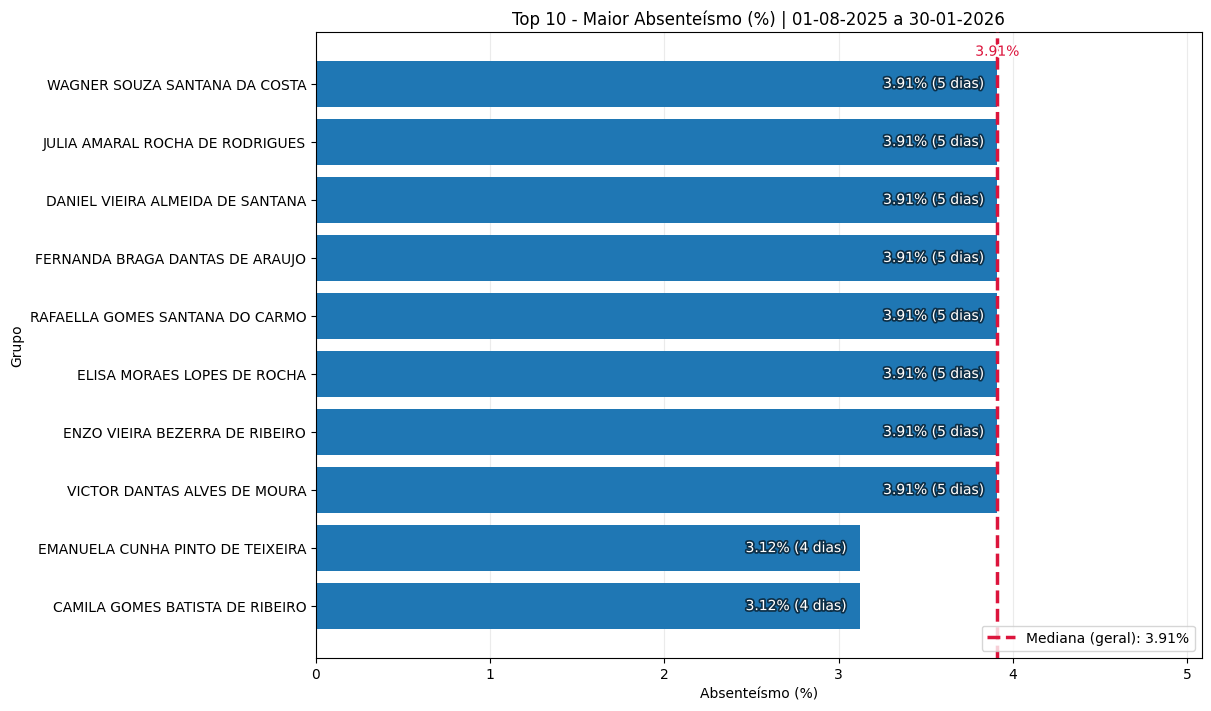

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as pe

TOP_N = 10


# Formatação correta de datas (Timestamp/Datetime -> str)
data_inicio_formatada = pd.to_datetime(inicio_dt).strftime('%d-%m-%Y')
data_fim_formatada    = pd.to_datetime(fim_dt).strftime('%d-%m-%Y')

# ----------------- Sanitização do DataFrame base -----------------
# Garante que a coluna de percentual exista e seja numérica
if "ABSENTEISMO_%" not in resultado_dados_geral.columns:
    raise KeyError("Coluna 'ABSENTEISMO_%' não encontrada em 'resultado_dados_geral'.")

resultado_dados_geral = resultado_dados_geral.copy()
resultado_dados_geral["ABSENTEISMO_%"] = pd.to_numeric(resultado_dados_geral["ABSENTEISMO_%"], errors="coerce").fillna(0.0)

# Detecta a coluna com dias ausentes de forma tolerante
possiveis_col_dias = ["DIAS_AUSENTES", "AUSENCIAS", "DIAS_FALTAS", "DIAS_PERDIDOS"]
col_dias = next((c for c in possiveis_col_dias if c in resultado_dados_geral.columns), None)

if col_dias is None:
    resultado_dados_geral["DIAS_AUSENTES"] = 0
    col_dias = "DIAS_AUSENTES"

# Seleciona Top N
top = (resultado_dados_geral
       .sort_values("ABSENTEISMO_%", ascending=False)
       .head(TOP_N)
       .copy())

# Mediana geral (segura contra NaN)
mediana = float(np.nanmedian(top["ABSENTEISMO_%"])) if len(top) > 0 else 0.0

# ---------- Labels do eixo Y ----------
if "NOMES" in top.columns:
    y_labels = top["NOMES"].astype(str)
else:
    # se não existir 'NOMES', usamos o index como rótulo
    y_labels = top.index.astype(str)

# Encurtar nomes longos
max_chars = 35
if hasattr(y_labels, "apply"):
    y_labels = y_labels.apply(lambda x: x if len(x) <= max_chars else x[:max_chars-3] + "...")
else:
    y_labels = y_labels.map(lambda x: x if len(x) <= max_chars else x[:max_chars-3] + "...")

# ---------- Figura ----------
fig_h = max(6, min(TOP_N, len(top)) * 0.6 + 1)  # altura mínima e ajustada ao N real
fig, ax = plt.subplots(figsize=(12, fig_h), constrained_layout=True)

bars = ax.barh(y_labels, top["ABSENTEISMO_%"], color="#1f77b4", zorder=2)
ax.invert_yaxis()

ax.set_title(f"Top {min(TOP_N, len(top))} - Maior Absenteísmo (%) | {data_inicio_formatada} a {data_fim_formatada}")
ax.set_xlabel("Absenteísmo (%)")
ax.set_ylabel("Funcionário" if "NOMES" in top.columns else "Grupo")

# Limites do eixo X com folga real (inclui mediana também)
max_val = float(top["ABSENTEISMO_%"].max()) if len(top) > 0 else 0.0
x_max = (max(max_val, mediana) * 1.30) if (max_val > 0 or mediana > 0) else 1.0
ax.set_xlim(0, x_max)

# ---------- Linha da mediana ----------
if np.isfinite(mediana):
    ax.axvline(
        mediana,
        color="crimson",
        linestyle="--",
        linewidth=2.5,
        zorder=3,
        label=f"Mediana (geral): {mediana:.2f}%"
    )

    # texto da mediana no topo (com contorno branco)
    txt_med = ax.text(
        mediana, 0.98, f"{mediana:.2f}%",
        transform=ax.get_xaxis_transform(),
        color="crimson", ha="center", va="top", fontsize=10,
        zorder=4, clip_on=True
    )
    txt_med.set_path_effects([pe.withStroke(linewidth=3, foreground="white", alpha=0.95)])

# ---------- Rótulos: % + dias ausentes ----------
# Ajustes de posicionamento
limiar = x_max * 0.10          # barra pequena
margem_interna = x_max * 0.015
margem_externa = x_max * 0.010

for bar, dias in zip(bars, top[col_dias].fillna(0).values):
    v = float(bar.get_width())
    y = bar.get_y() + bar.get_height()/2

    # texto completo que você quer exibir
    # se dias for float, convertemos para int com segurança
    try:
        dias_int = int(round(float(dias)))
    except Exception:
        dias_int = 0

    label = f"{v:.2f}% ({dias_int} dias)"

    if v >= limiar:
        # dentro da barra (branco) + contorno
        txt = ax.text(
            v - margem_interna, y, label,
            va="center", ha="right",
            color="white", fontsize=10,
            zorder=4, clip_on=True
        )
        txt.set_path_effects([pe.withStroke(linewidth=2.5, foreground="black", alpha=0.6)])
    else:
        # fora da barra com caixinha branca
        ax.text(
            v + margem_externa, y, label,
            va="center", ha="left",
            color="black", fontsize=10,
            zorder=4, clip_on=True,
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.95)
        )

ax.grid(axis="x", alpha=0.25, zorder=0)
ax.legend(loc="lower right", frameon=True)

plt.show()

### Gráfico Mês
Grafico com absenteismo durantes os meses do periodo de 01-10-2025 a 21-01-2026

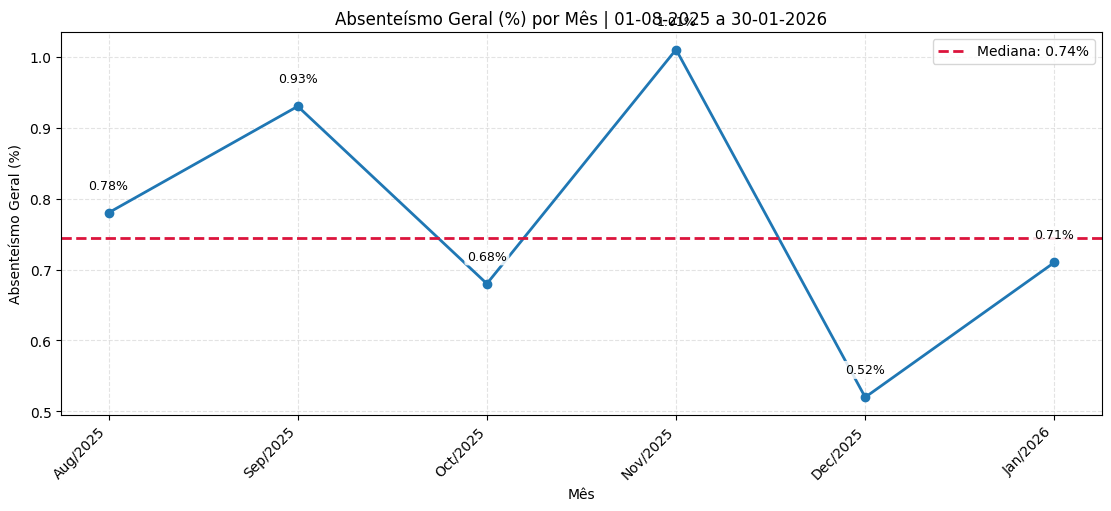

In [38]:
# --- 1) Garantir que temos os dados necessários ---
# premissas: resumo_geral_mensal tem as colunas: MES (Period[M]), MES_LABEL (str), ABSENTEISMO_GERAL_% (float)
graf_geral = resumo_geral_mensal.copy()

# ordena cronologicamente
graf_geral = graf_geral.sort_values("MES").reset_index(drop=True)

# --- 2) Preparar vetores do gráfico ---
mes_labels = graf_geral["MES_LABEL"].astype(str).tolist()
y = graf_geral["ABSENTEISMO_GERAL_%"].astype(float).to_numpy()
x = np.arange(len(mes_labels))
mediana = float(np.nanmedian(y)) if len(y) else 0.0

# (opcional) título com período, se tiver inicio_dt/fim_dt:
try:
    data_inicio_formatada = pd.to_datetime(inicio_dt).strftime("%d-%m-%Y")
    data_fim_formatada    = pd.to_datetime(fim_dt).strftime("%d-%m-%Y")
    titulo_periodo = f" | {data_inicio_formatada} a {data_fim_formatada}"
except Exception:
    titulo_periodo = ""

# --- 3) Plot ---
fig, ax = plt.subplots(figsize=(11, 5), constrained_layout=True)

ax.plot(x, y, marker="o", linewidth=2, color="#1f77b4")

# linha da mediana
ax.axhline(
    mediana, color="crimson", linestyle="--", linewidth=2,
    label=f"Mediana: {mediana:.2f}%"
)

# títulos e eixos
ax.set_title(f"Absenteísmo Geral (%) por Mês{titulo_periodo}")
ax.set_xlabel("Mês")
ax.set_ylabel("Absenteísmo Geral (%)")

# eixo X
ax.set_xticks(x)
ax.set_xticklabels(mes_labels, rotation=45, ha="right")

# grade
ax.grid(True, linestyle="--", alpha=0.35)

# folga e rótulos nos pontos
if len(y):
    y_min, y_max = np.nanmin(y), np.nanmax(y)
    range_y = max(y_max - y_min, 1e-6)
    offset = range_y * 0.06 if y_max != y_min else 0.5

    for xi, yi in zip(x, y):
        if np.isfinite(yi):
            ax.text(
                xi, yi + offset, f"{yi:.2f}%",
                ha="center", va="bottom", fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.85)
            )

ax.legend(loc="best")
plt.show()

### Gráfico Dias da Semana

Grafico com absenteismo dos dias da semana do periodo de 01-10-2025 a 21-01-2026

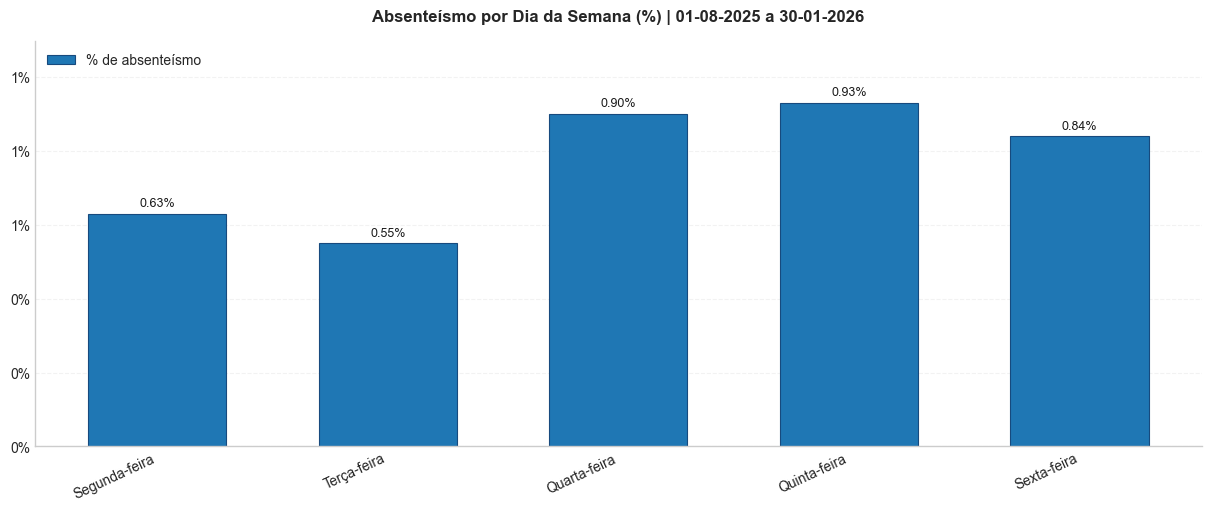

In [39]:
dias = tabela_dia_semana["DIA_SEMANA"].astype(str).tolist()
pct  = tabela_dia_semana["ABSENTEISMO_%"].astype(float).to_numpy()

x = np.arange(len(dias))

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)

bars = ax.bar(
    x, pct, width=0.6,
    color="#1f77b4",
    edgecolor="#174a7e",
    linewidth=0.8,
    label="% de absenteísmo"
)

ax.set_title(
    f"Absenteísmo por Dia da Semana (%) | {data_inicio_formatada} a {data_fim_formatada}",
    pad=14, fontweight="bold"
)

ax.set_xticks(x)
ax.set_xticklabels(dias, rotation=25, ha="right")

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))

ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.grid(axis="x", visible=False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

max_pct = float(np.nanmax(pct)) if len(pct) else 1.0
top = max_pct * 1.18
ax.set_ylim(0, top if top > 0 else 1)

ax.bar_label(
    bars,
    labels=[f"{(v if np.isfinite(v) else 0):.2f}%" for v in pct],
    padding=3,
    fontsize=9,
    color="#1a1a1a"
)

ax.legend(frameon=False, loc="upper left")

plt.show()


### Gráfico por Missão (Top 10)
Grafico com absenteismo por missão (top 10) do periodo de 01-10-2025 a 21-01-2026

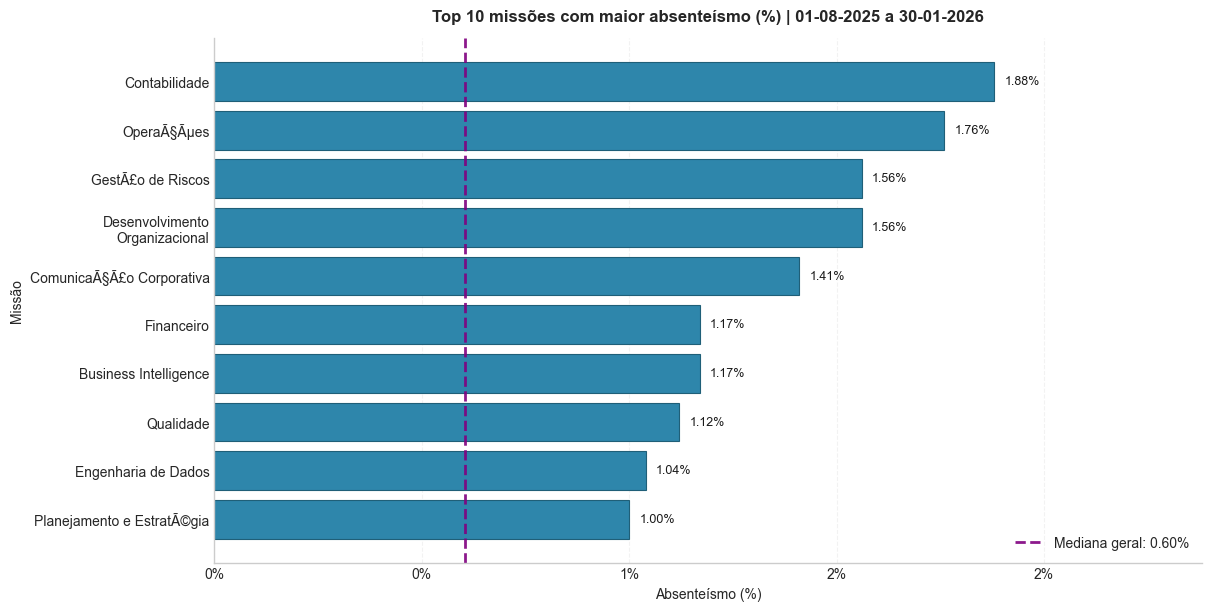

In [40]:
top_n = 10
top = (resultado_missao
       .sort_values("ABSENTEISMO_%", ascending=False)
       .head(top_n)
       .copy())

# Mediana geral
mediana_geral = float(resultado_missao["ABSENTEISMO_%"].median())

# (Opcional) encurtar/quebrar nomes muito longos
# Ajuste width=28 conforme seu layout
top["MISSAO_FMT"] = top["MISSAO"].astype(str).apply(lambda s: "\n".join(textwrap.wrap(s, width=28)))

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

bars = ax.barh(top["MISSAO_FMT"], top["ABSENTEISMO_%"],
               color="#2E86AB", edgecolor="#1f5f78", linewidth=0.8)

ax.invert_yaxis()

# Linha vertical da mediana
ax.axvline(
    mediana_geral,
    color="purple",
    linestyle="--",
    linewidth=2,
    alpha=0.9,
    label=f"Mediana geral: {mediana_geral:.2f}%"
)

# Títulos e eixos
ax.set_title(
    f"Top {top_n} missões com maior absenteísmo (%) | {data_inicio_formatada} a {data_fim_formatada}",
    pad=12, fontweight="bold"
)
ax.set_xlabel("Absenteísmo (%)")
ax.set_ylabel("Missão")

# Eixo X como percent
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Grid mais suave
ax.grid(axis="x", linestyle="--", alpha=0.25)
ax.grid(axis="y", visible=False)

# Visual clean
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# --- Ajuste de limites para caber rótulos ---
vals = top["ABSENTEISMO_%"].to_numpy(dtype=float)
max_v = float(np.nanmax(vals)) if len(vals) else 1.0

# Folga no final do eixo X (ex.: 12% do máximo, mínimo de 0.5)
pad = max(0.5, max_v * 0.12)
ax.set_xlim(0, max_v + pad)

# --- Rótulos nas barras (inteligente: fora quando cabe; dentro se estiver apertado) ---
xmax = ax.get_xlim()[1]
for rect, v in zip(bars, vals):
    y = rect.get_y() + rect.get_height()/2

    # Se o valor estiver muito perto do limite, coloca o texto "dentro" da barra
    if v > xmax * 0.88:
        ax.text(v - pad*0.25, y, f"{v:.2f}%",
                va="center", ha="right", fontsize=9,
                color="white", fontweight="bold")
    else:
        ax.text(v + pad*0.05, y, f"{v:.2f}%",
                va="center", ha="left", fontsize=9,
                color="#1a1a1a")

# Legenda limpa
ax.legend(frameon=False, loc="lower right")

plt.show()